# Exploring Hypotheses on Synthetic Functions  

The purpose of this notebook is to find out more about the effect of the sampling bias and measures against it. 

In particular, we will explore the following hypotheses: 

* Why should we compute the PDP on uniformly distributed test data? 
* What is the effect of the sampling bias on the PDP? 
* How can we capture this effect an tell the user? 
* How can we reduce the sampling bias? 



In [136]:
# test function
library("smoof")
library("ParamHelpers")

# data handling
library("data.table")
library(BBmisc)

# visualization
library("plot3D")
library("ggplot2")
library("GGally")
library("gridExtra")
library("rpart.plot")
library("rattle")
library("RColorBrewer")
library("DiceKriging")

# mlrMBO
library("mlrMBO")
library("mlr")

# iml methods
library("iml")

theme_set(theme_bw())

source("mbo_helpers.R")
source("pdp_helpers.R")

devtools::load_all("../../customtrees/")

Loading customtrees



In [53]:
options(repr.plot.width=10, repr.plot.height=10)


## Scenario - Optimizing a Synthetic Test Function via mlrMBO

### Preparation: Objective Function

We optimize the 3D StyblinkskiTang function. 

In [166]:
obj1 = makeSingleObjectiveFunction(name = "StyblinkskiTang3D", fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 5))
)

obj = obj1

In [167]:
# obj2 = makeSingleObjectiveFunction(name = "Rastrigin", fn = function(x) {
#         20 + sum(x^2 - 10 * cos(2 * pi * x))
#     }, 
#     par.set = makeParamSet(makeNumericVectorParam(id = "x", len = 2, lower = - 5, upper = 3))# 
# )

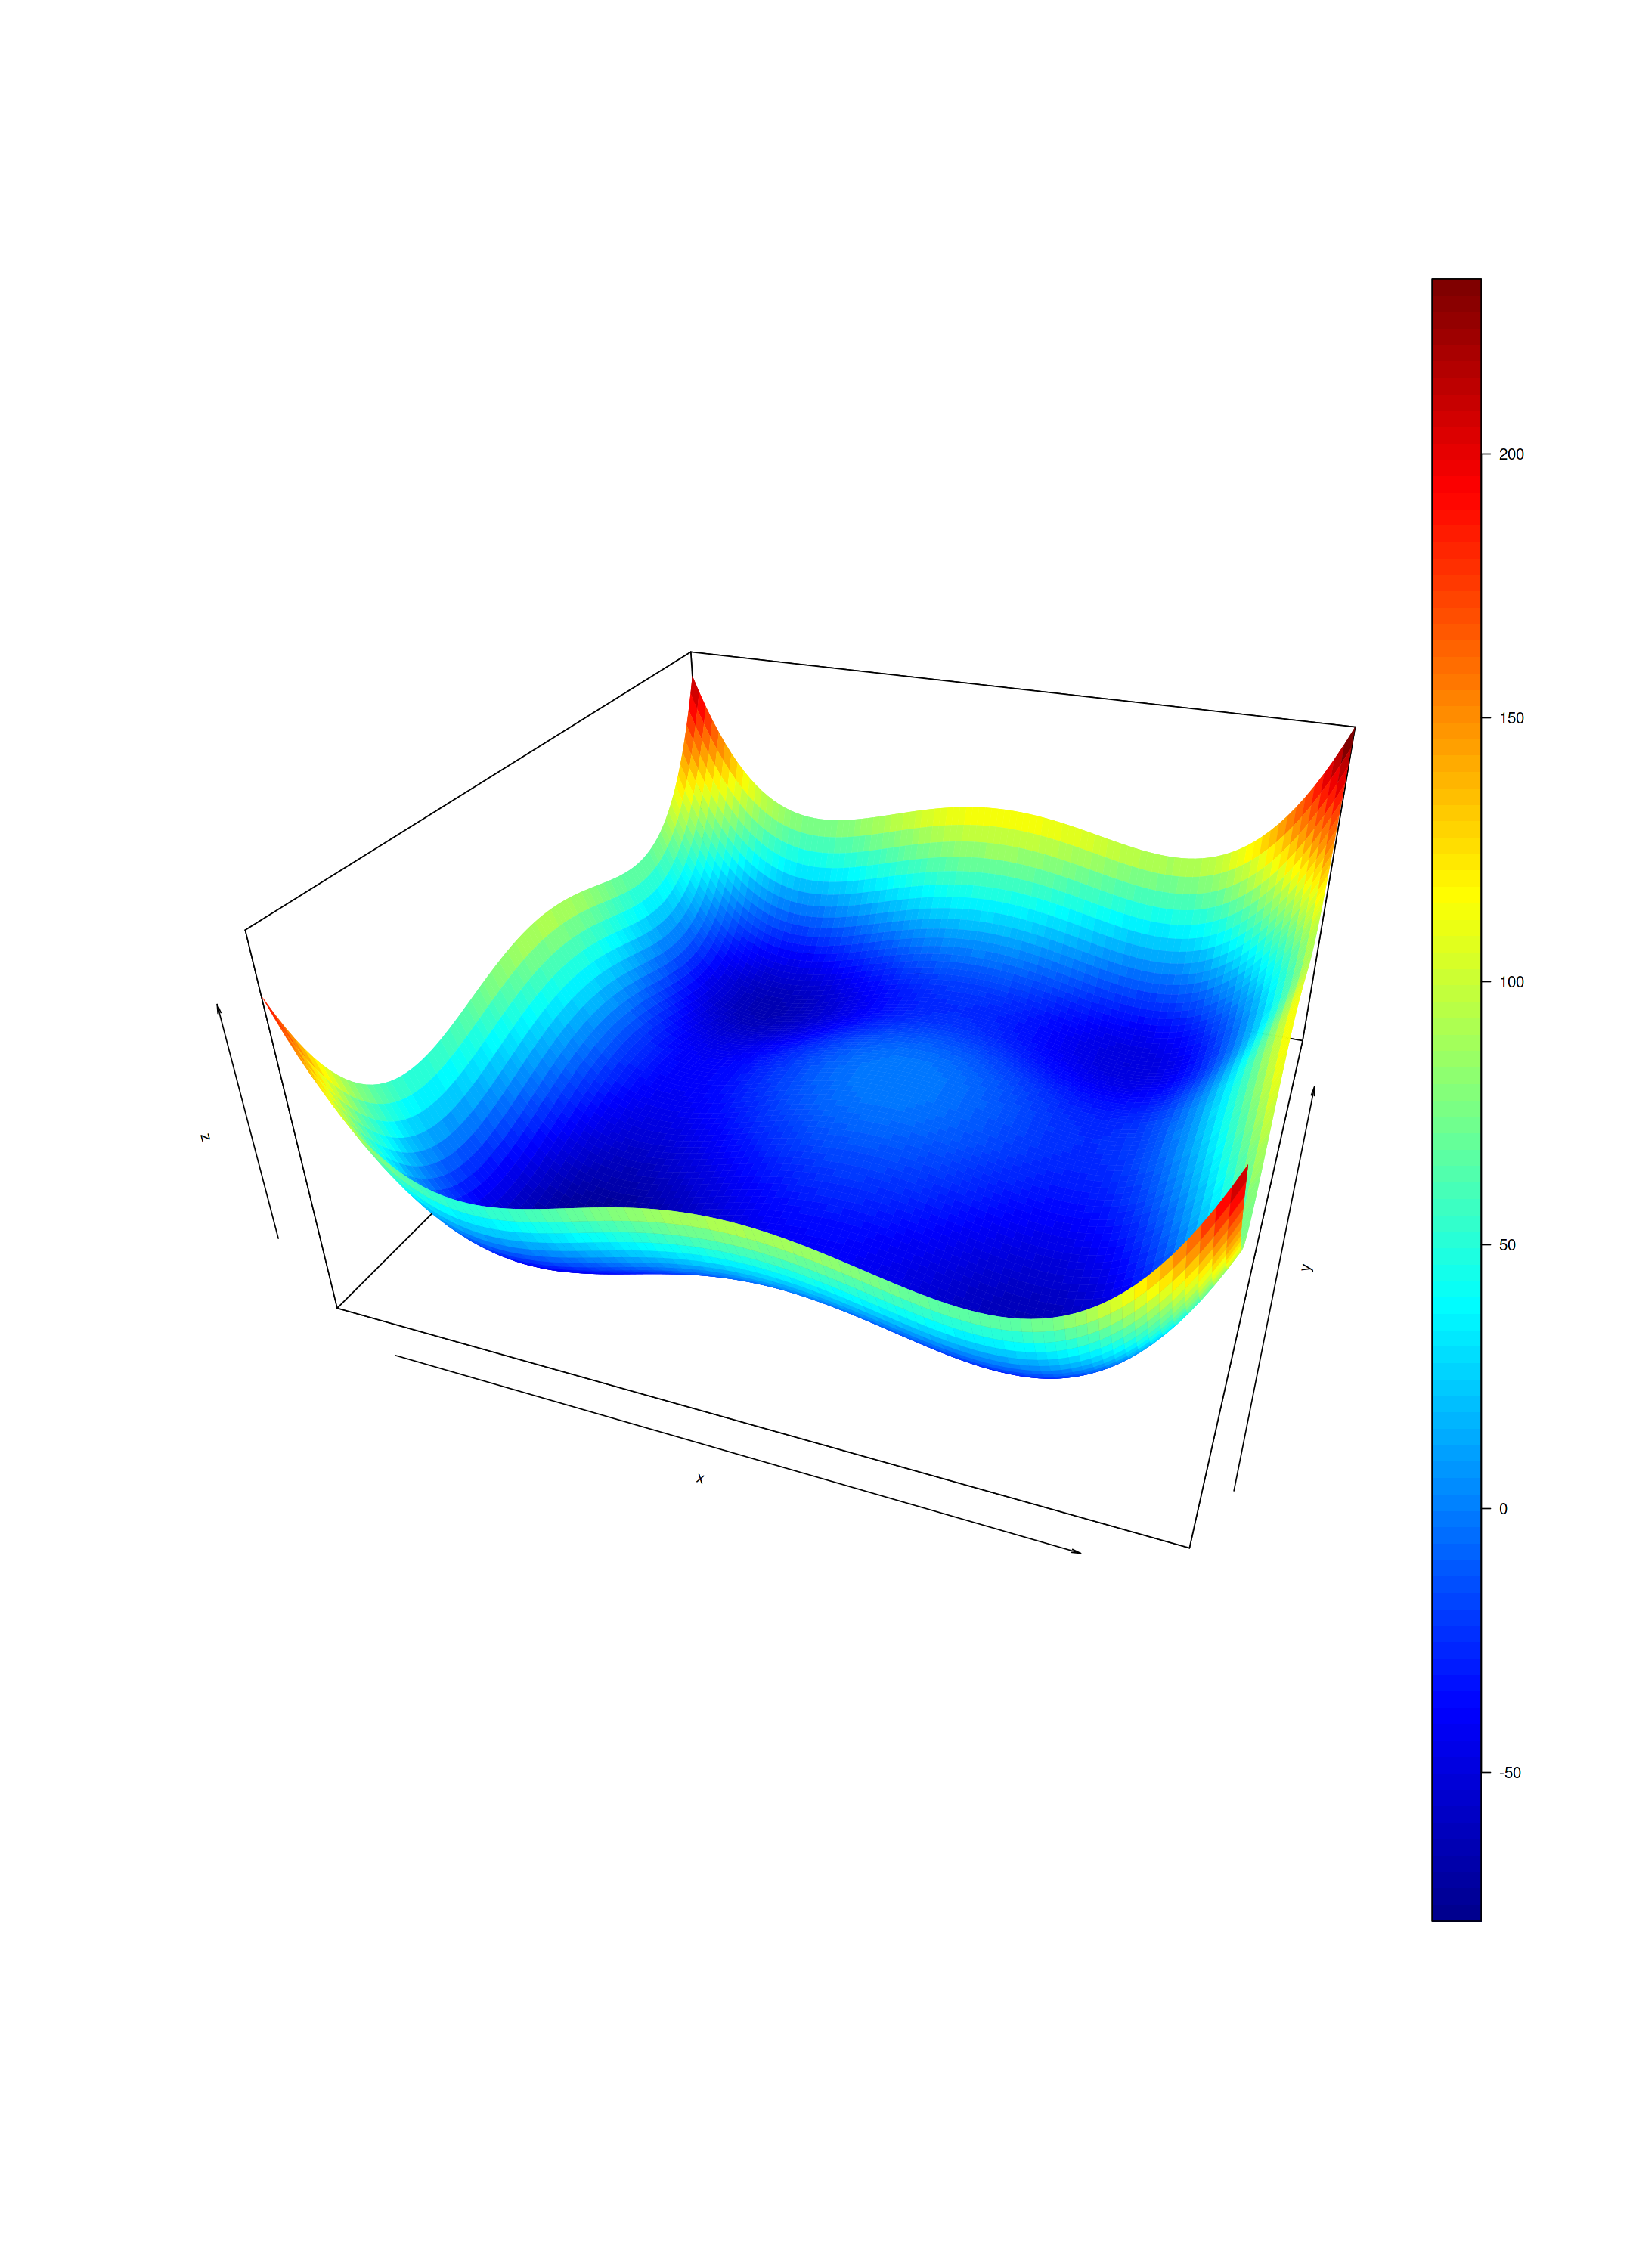

In [168]:
ps = getParamSet(obj1)

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x2 <- x1
y = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj1))
          
persp3D(x1, x2, y, theta = 20, phi = 30, expand = 0.5, border = NA)

In [169]:
# ps = getParamSet(obj2)

# x11 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
# x22 <- x11
# y2 = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj2))
          
# persp3D(x11, x22, y2, theta = 20, phi = 30, expand = 0.5, border = NA)

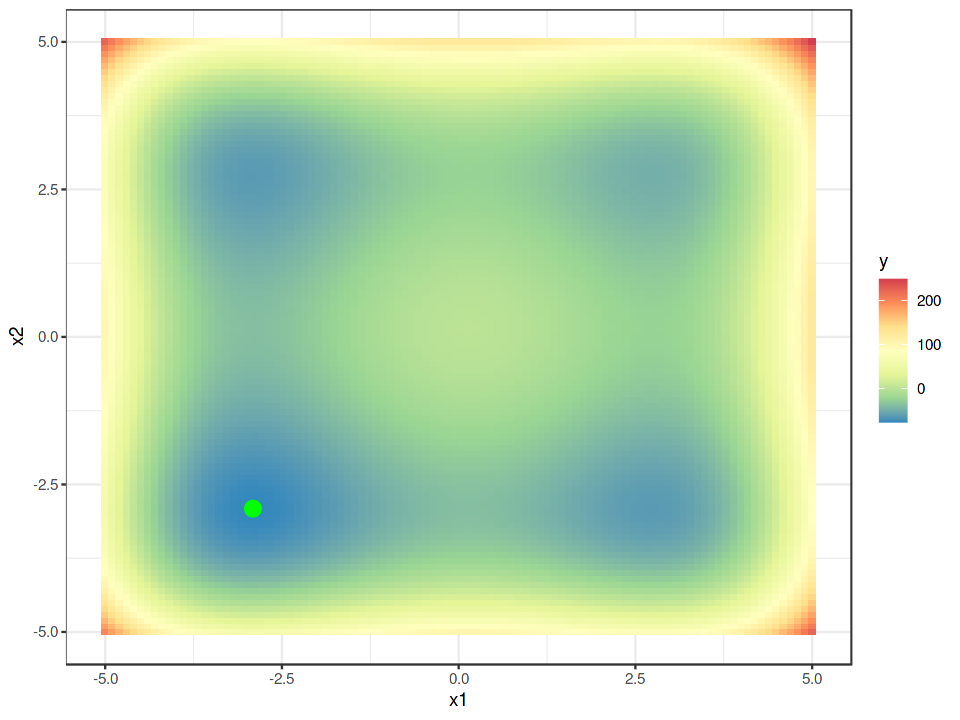

In [170]:
options(repr.plot.width=8, repr.plot.height=6)

gg <- expand.grid(x1 = x1, x2 = x2)
gg$y = apply(gg, 1, obj1)

# gg2 <- expand.grid(x1 = x11, x2 = x22)
# gg2$y = apply(gg2, 1, obj2)


p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)

# p_obj_2 = ggplot() + geom_tile(data = gg2, aes(x = x1, y = x2, fill = y))
# p_obj_2 = p_obj_2 + scale_fill_distiller(palette = "Spectral")
# p_obj_2 = p_obj_2 + geom_point(data = data.frame(x = 0, y = 0), aes(x = x, y = y), colour = "green", size = 4)

p_obj_1

### Preparation: Creating MBO Runs

Next, we create `mlrMBO` runs as well as a model fitted on the randomLHS data. 

In [171]:
createMBOrun(fun = obj, max.evals = 50, lambda = 0.1, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds", seed = 1234)

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generat

In [172]:
createMBOrun(fun = obj, max.evals = 50, lambda = 1, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds", seed = 1234)

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generat

In [173]:
createMBOrun(fun = obj, max.evals = 50, lambda = 2, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_2.rds", seed = 1234)

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generat

In [174]:
createMBOrun(fun = obj, max.evals = 50, lambda = 10, store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds", seed = 1234)

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”
Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generat

In [175]:
createMBOrun(fun = obj, max.evals = 50, type = "LHS", store_path = "../synthetic/mlrmbo_run_StyblinkskiTang3D_lhs.rds", init_size = 50, seed = 1234)

In [176]:
runs = list(lambda01 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_01.rds"), 
            lambda1 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_1.rds"),
            lambda2 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_2.rds"),
            lambda10 = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_10.rds"), 
            lhs = readRDS("../synthetic/mlrmbo_run_StyblinkskiTang3D_lhs.rds"))

In [177]:
types = get_types_of_runs(runs)
models = extract_models(runs)
names(models) = types
opdf = concatenate_runs(runs)

opdf$type = factor(opdf$type, levels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1"), labels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1")) 

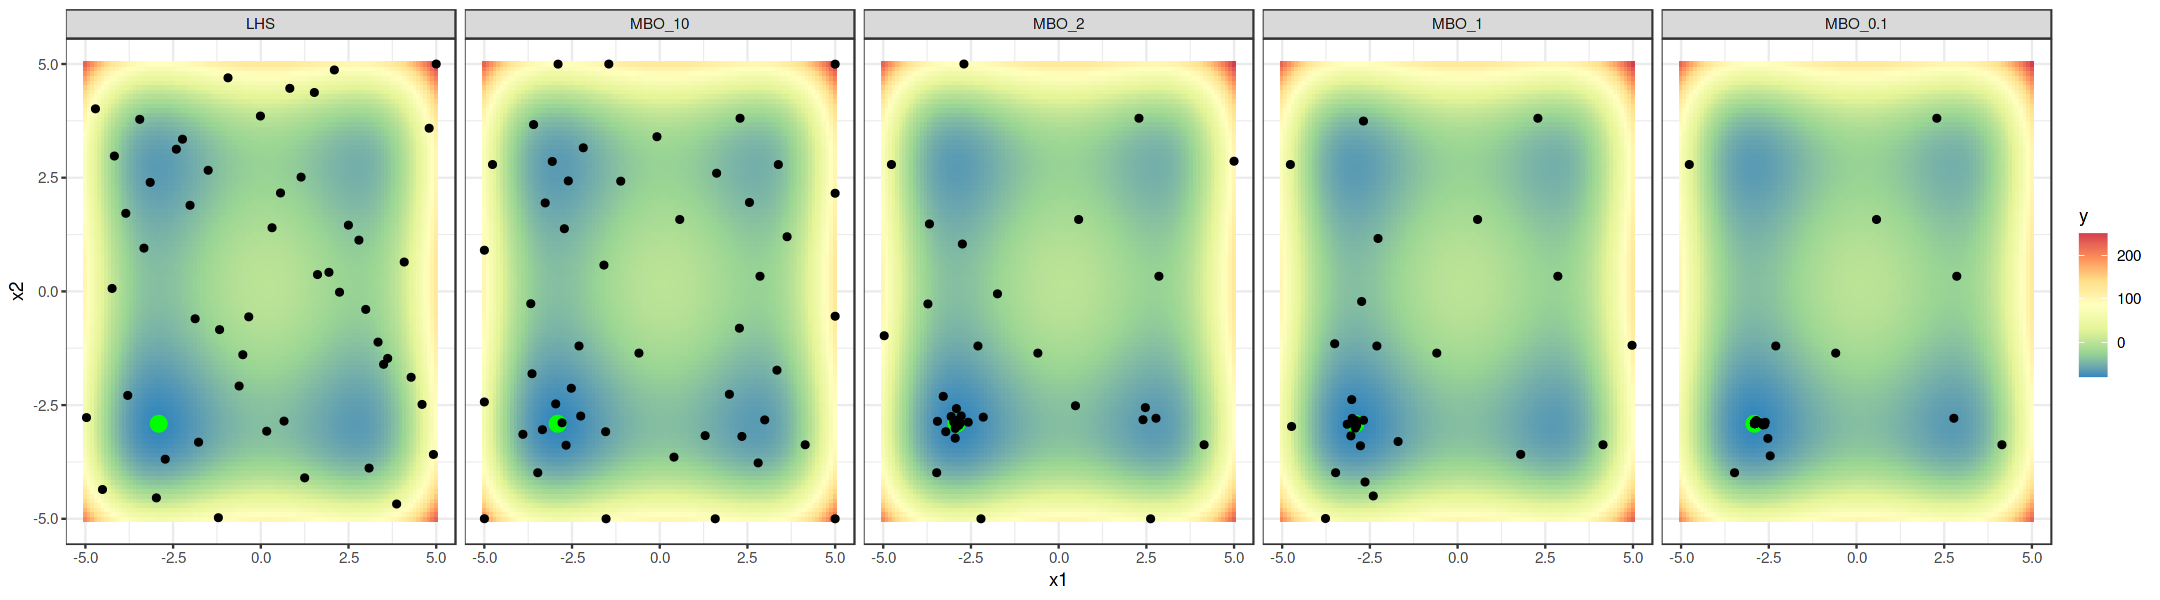

In [178]:
options(repr.plot.width=18, repr.plot.height=5)

p1 = p_obj_1 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p1 = p1 + facet_grid(. ~ type) 
p1

### Preparation: Investigating the Fit

In [179]:
gg = generateGridDesign(par.set = ps, resolution = 50)
gg$y = apply(gg, 1, obj1)

In [180]:
preds = lapply(names(models), function(idx) {
    pp = predict_on_grid(models[[idx]], gg)
    pp$type = idx
    pp
})
preds = do.call(rbind, preds)

preds$type = factor(preds$type, levels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1"), labels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1")) 

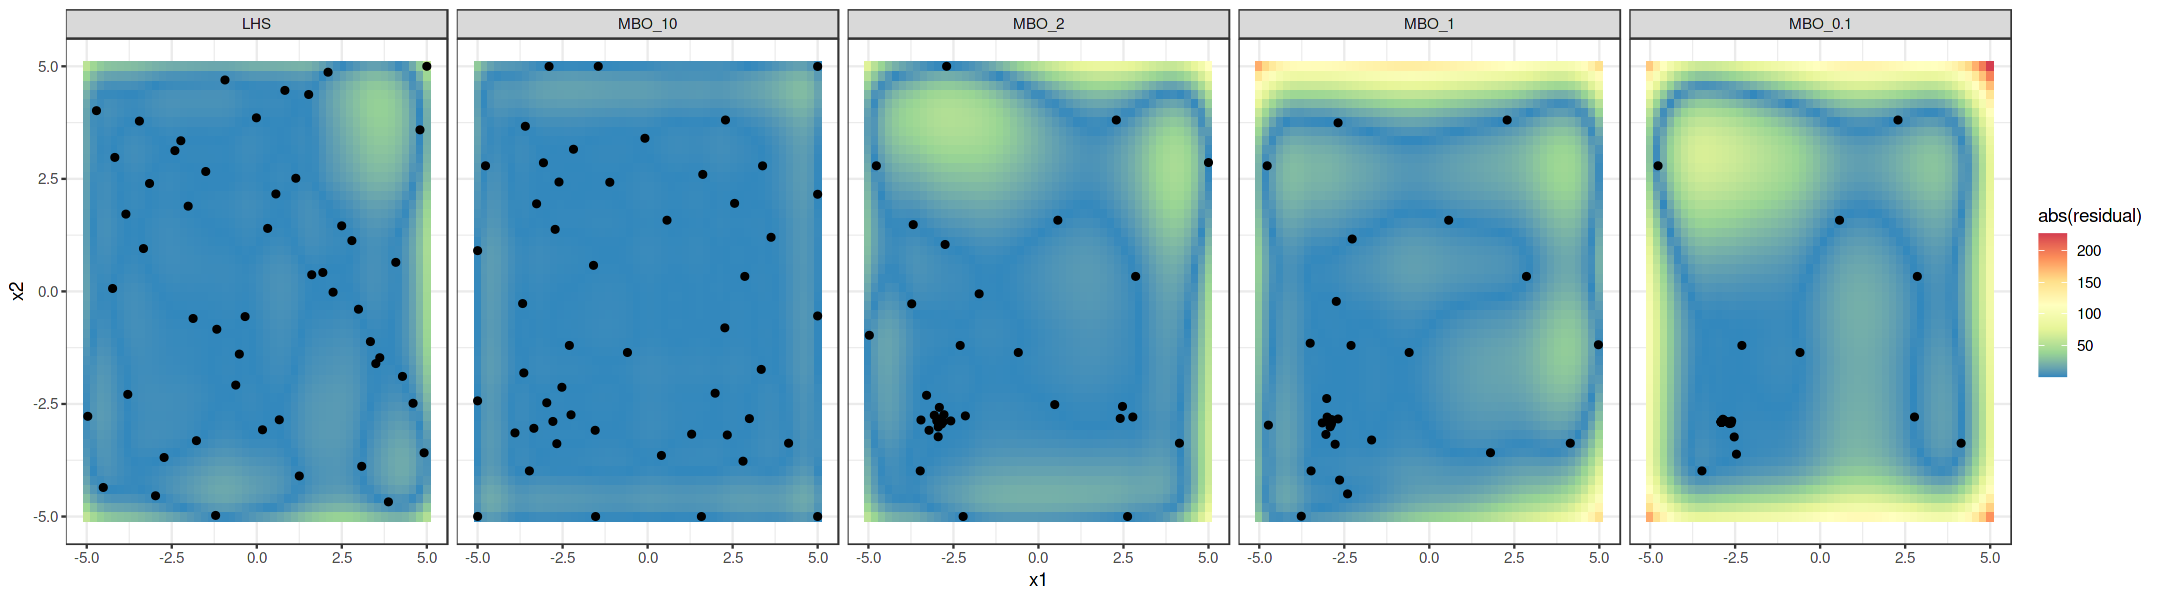

In [181]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

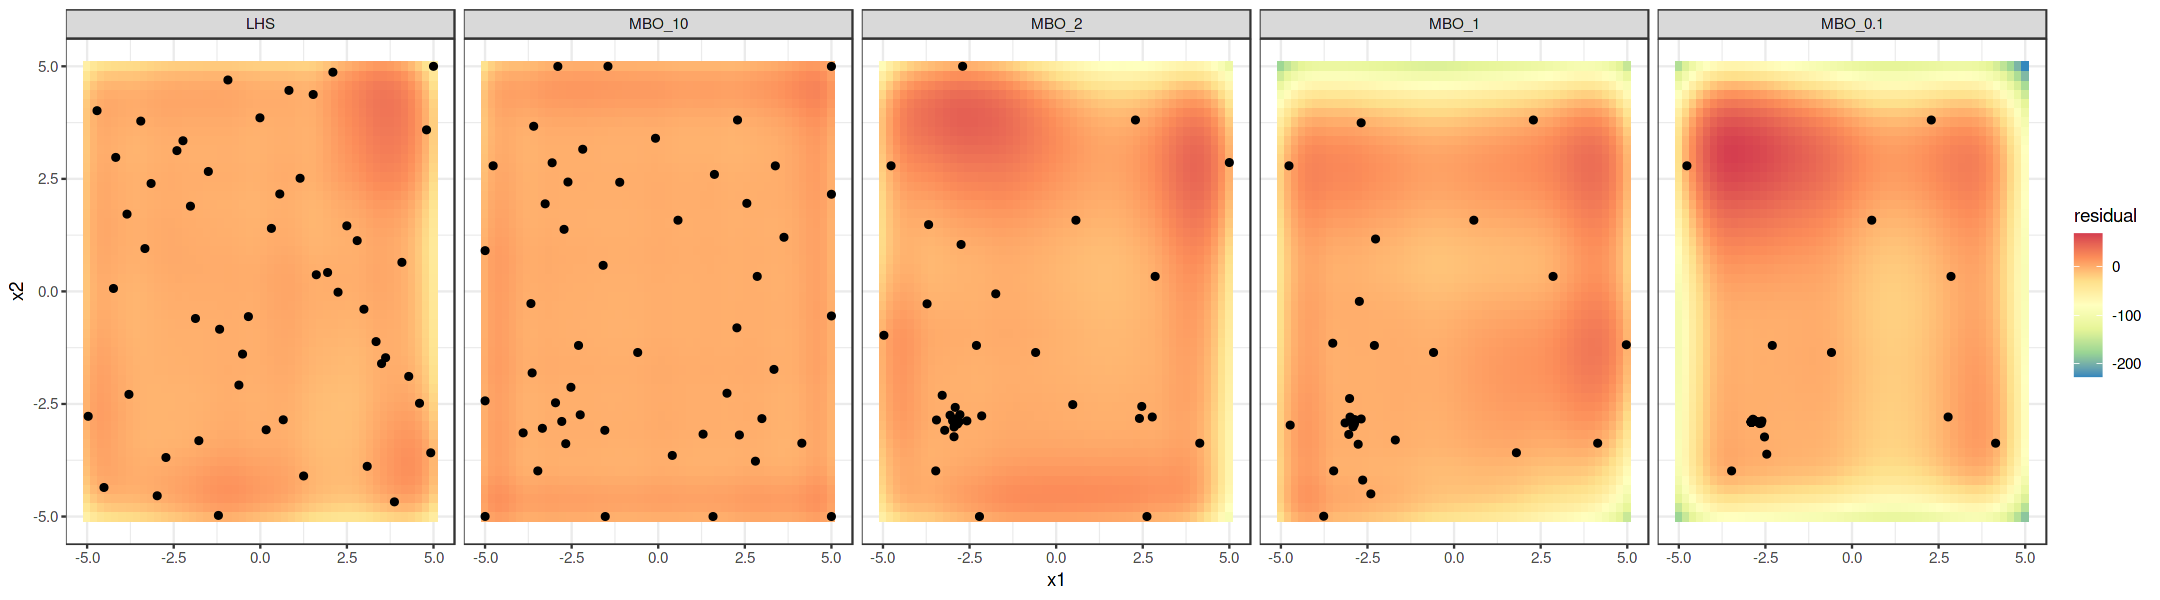

In [182]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = residual))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

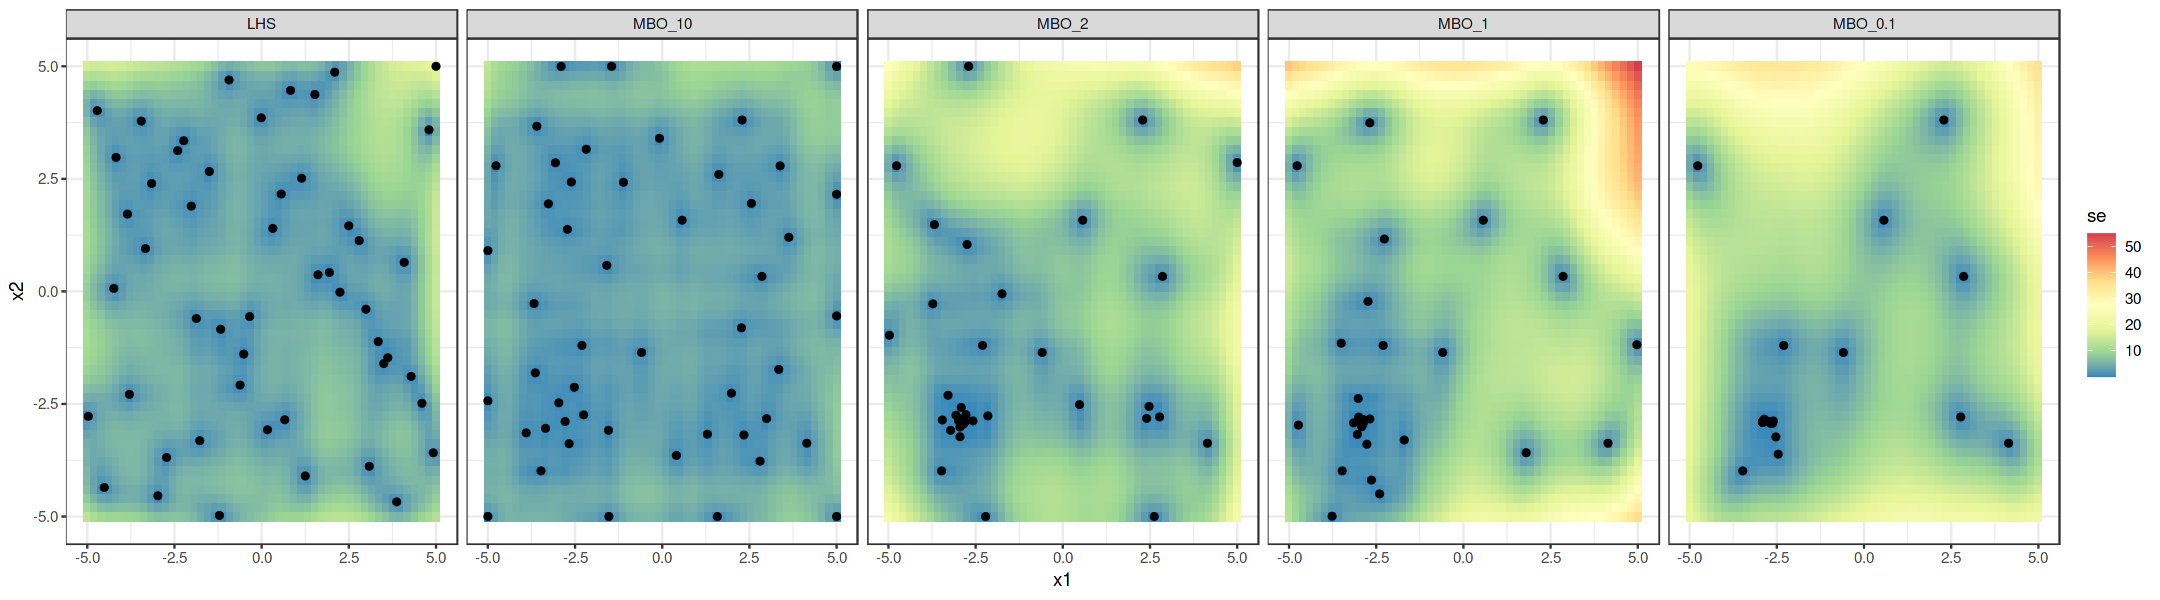

In [183]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

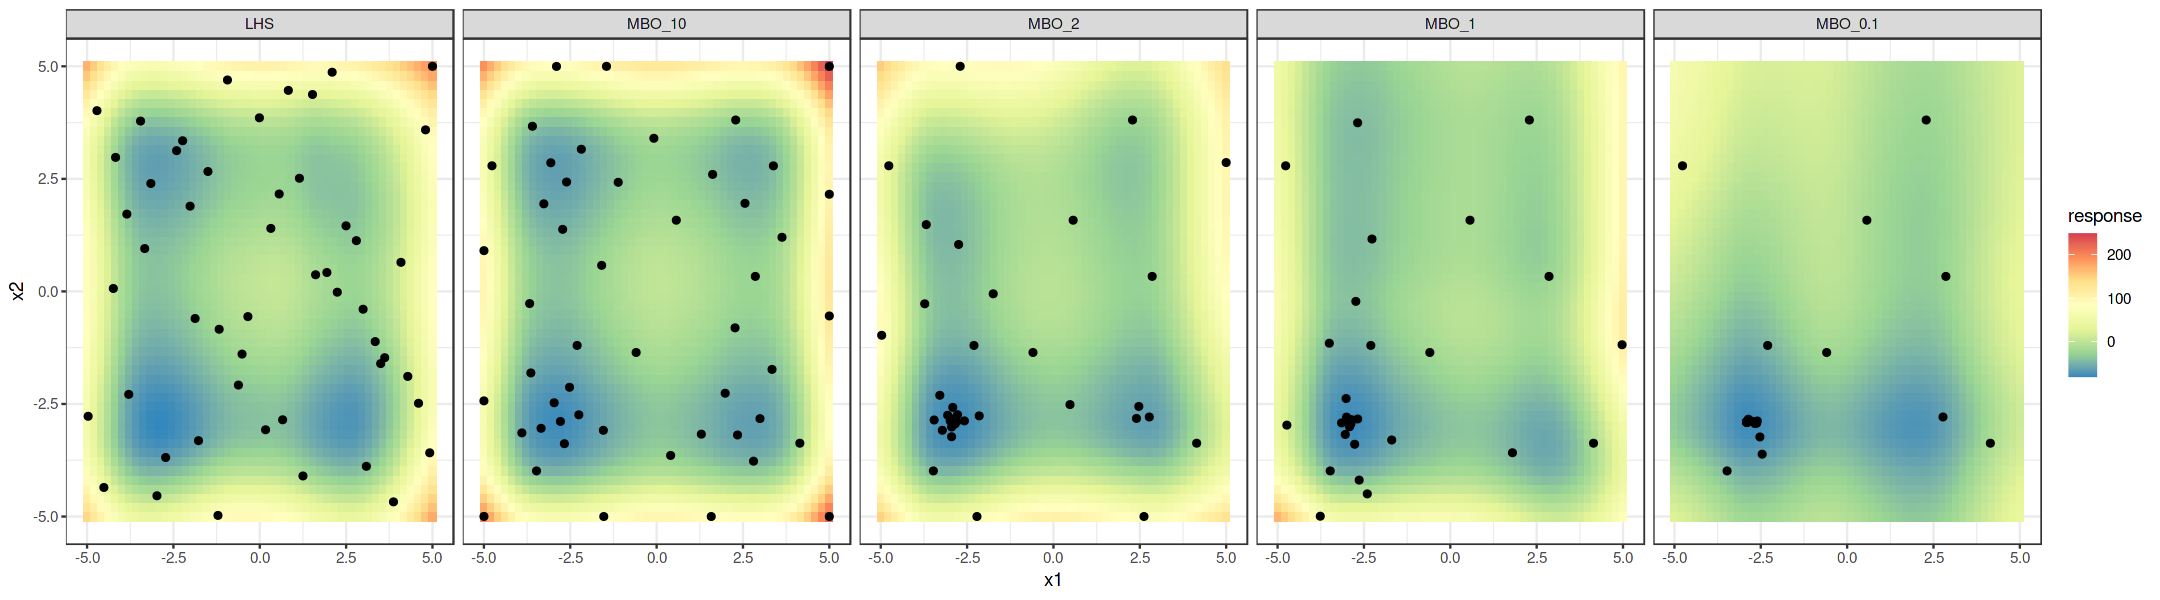

In [184]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = response))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

# High error means over-estimation 

### Question 1: Computing the PDP on Training or Test Data? 

A partial dependence plot tries to approximate the following: 

\begin{align*}
\hat f(x_S) & = \mathbb{E}_{x_C}[\hat f(x_S, x_C)] = \int \hat f(x_S, x_C) d\mathbb{P}(x_C)
\end{align*}

The mathematical correct variants of the ground-truth for $\hat f = f$ look like this: 

* Data situation 1: Ground-truth objective and $\mathbb{P}$ is the uniform distribution (ideal world)

\begin{align*}
\hat f_1(x_1) & = (-25 + 15 x_1 - 48 x_1^2 + 3 x_1^4) / 6 \\
\hat f_2(x_1) & = 8 x_1^2 - 80 cos(2 \pi x_1) + 632/3
\end{align*}

* Data situation 2: Ground-truth objective and $\mathbb{P}$ is the distribution from a perfect optimizer which immediately detects the optimum at $x^* = (-2.903.., - 2.903)$.

\begin{align*}
\hat f(x_1) & = 0.5 (x_1^4 - 16 x_1^2 + 5 x_1 - 78.3323) \\
\hat f_2(x_1) &= 20 + x_1^2 - 10 \cos(2 \pi x_1) - 10
\end{align*}

If we fit a PDP on the MBO data we usually approximate something in between. 

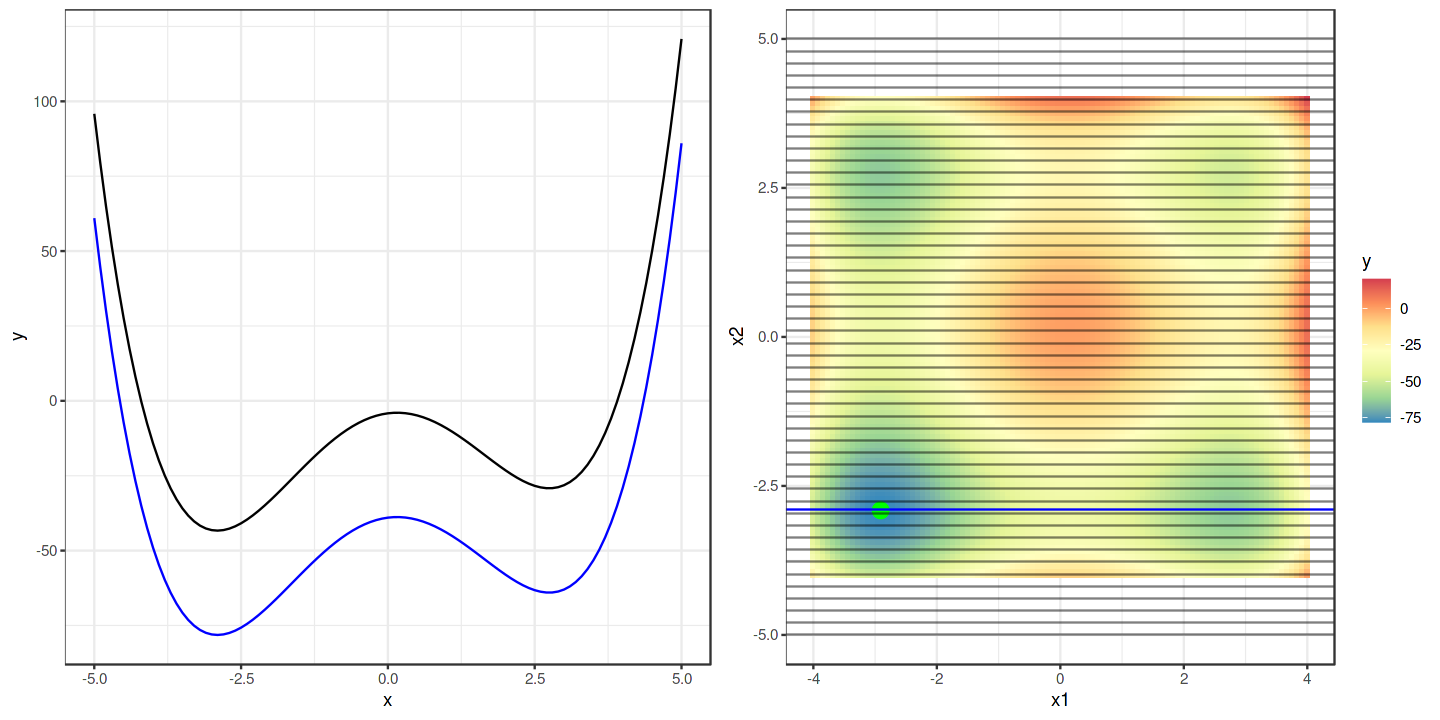

In [106]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 6 * (3 * x^4 - 48 * x^2 + 15 * x - 25))
lines = seq(-5, 5, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 2 * (x^4 - 16 * x^2 + 5 * x - 78), colour = "blue")
p2 = p_obj_1 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

In case 1 we are interested in the average feature effect of $x_1$ on $y$.

In case 2 we are interested in the feature effect of $x_1$ on $y$ given $x_2 = x_2^*$.

Usually, what we approximate is something in between but we converge to scenario 2. 

### Question 2: What is the Sampling Bias? 

We compare the partial dependence plots against the ground-truth PDP. 

In [185]:
data = generateRandomDesign(100, getParamSet(obj))

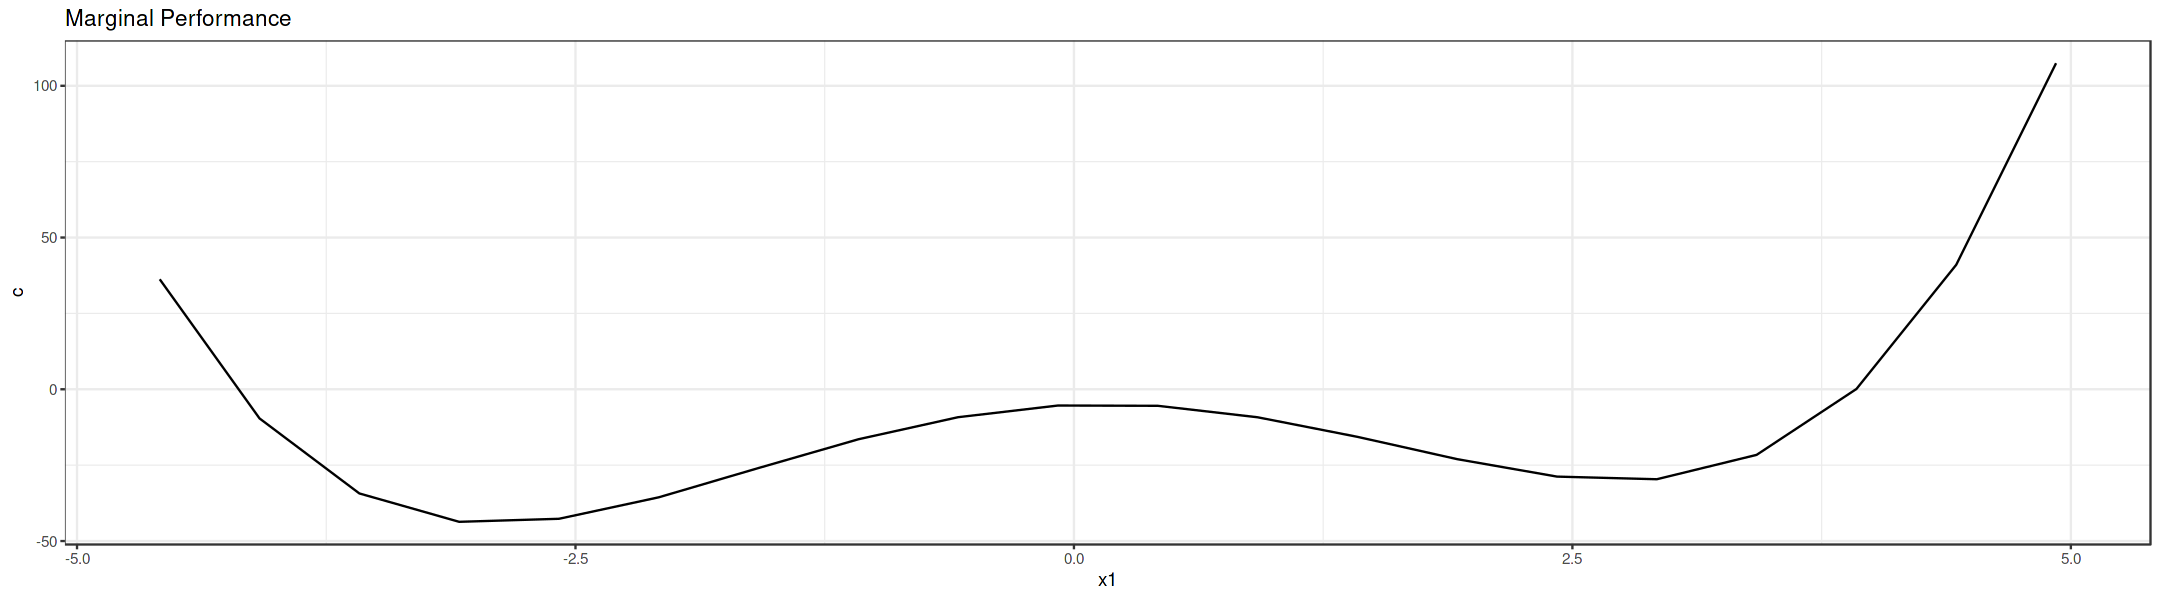

In [186]:
marginal_gt = marginal_effect(obj, "x1", data)

(p = ggplot(data = marginal_gt, aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c")))

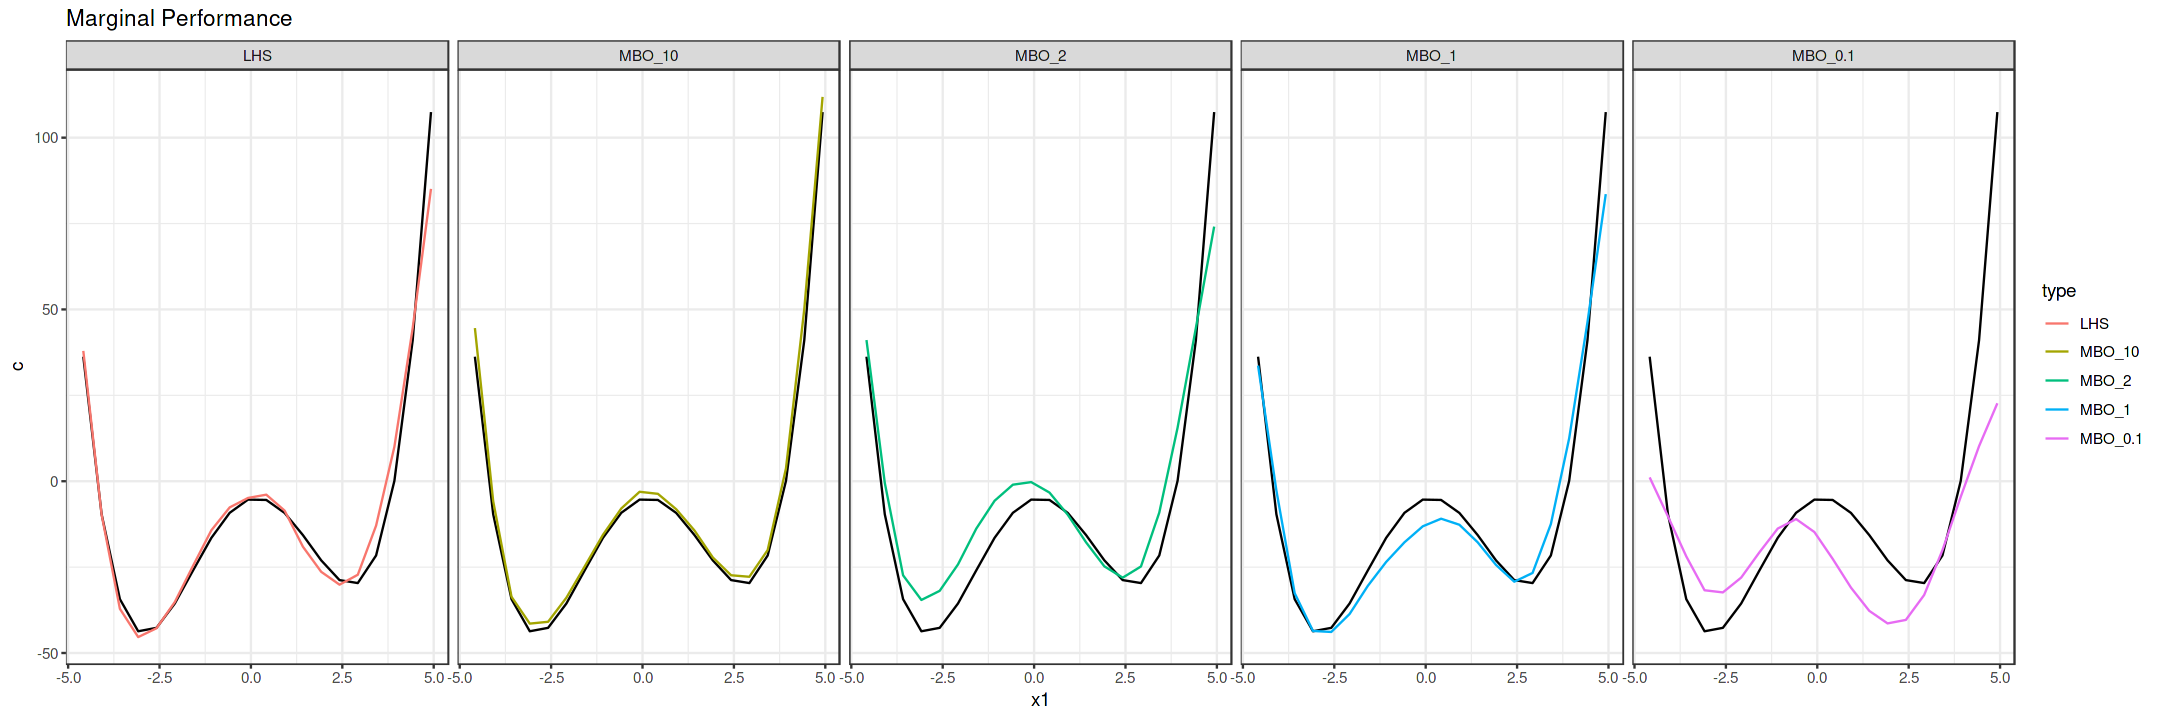

In [187]:
options(repr.plot.width=18, repr.plot.height=6)

marginal_pd = lapply(names(models), function(m) {
    pp = predicted_marginal_effect(models[[m]], "x1", data)
    pp$type = m
    pp
})
                     
marginal_pd = do.call(rbind, marginal_pd)
marginal_pd$type = factor(marginal_pd$type, levels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1"), labels = c("LHS","MBO_10","MBO_2", "MBO_1", "MBO_0.1")) 
marginal_pd = as.data.table(marginal_pd)

p + geom_line(data = marginal_pd, aes(x = x1, y = mean, colour = type)) + facet_grid(. ~ type)                         

In [155]:
# Capturing the bias in numbers 

# Compute the absolute deviation

res = lapply(names(models), function(m) {
    mm = marginal_pd[type == m, ]
    mm = merge(mm, marginal_gt, by = "x1")
    mm$dev_abs = mm$mean.x - mm$mean.y
    c(mean(abs(mm$dev_abs)), sd(mm$dev_abs)) 
})

res = do.call(rbind, res)
rownames(res) = names(models)
colnames(res) = c("Mean Abs. Difference", "SD Abs. Difference")
res

,Mean Abs. Difference,SD Abs. Difference
MBO_0.1,5.641792,8.9269119
MBO_1,4.051402,5.1029621
MBO_2,3.650971,4.5066904
MBO_10,0.792451,0.9142051
LHS,1.192309,2.1841215


### Question 3: How Can We Capture this Effect? 

We use the uncertainty to capture this effect. 

#### Variant 1 (Partial Dependence Plot over the Posterior Variance)

$$
    \hat s(\lambda_S) = \sqrt{\frac{1}{n^2} \sum_{i = 1}^n \hat s^2(\lambda^{(i)})} = \frac{1}{n} \sqrt{ \sum_{i = 1}^n \hat s^2(\lambda^{(i)})}
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 2 (Partial Dependence Plot over Standard Deviation)

At least in my opinion, this is not mathematically valid...?

$$
    \hat s(\lambda_S) = \frac{1}{n}  \sum_{i = 1}^n \hat s(\lambda^{(i)})
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 3 (Partial Dependence Taking into Account GP Covariance)

$$
    \hat s(\lambda_S) = \frac{1}{n} \sqrt{\sum_{i,j} K^{(post)}_{i,j}}
$$

In [188]:
results = list()

for (method in c("pdp_sd", "pdp_var", "pdp_var_gp", "thompson")) {
    res = lapply(names(models), function(m) {
        pp = marginal_effect_sd_over_mean(models[[m]], "x1", data, method = method)
        pp$type = m
        pp
    })
    res = do.call(rbind, res)
    res$method = method
    results[[method]] = res
}

In [189]:
results = do.call(rbind, results)

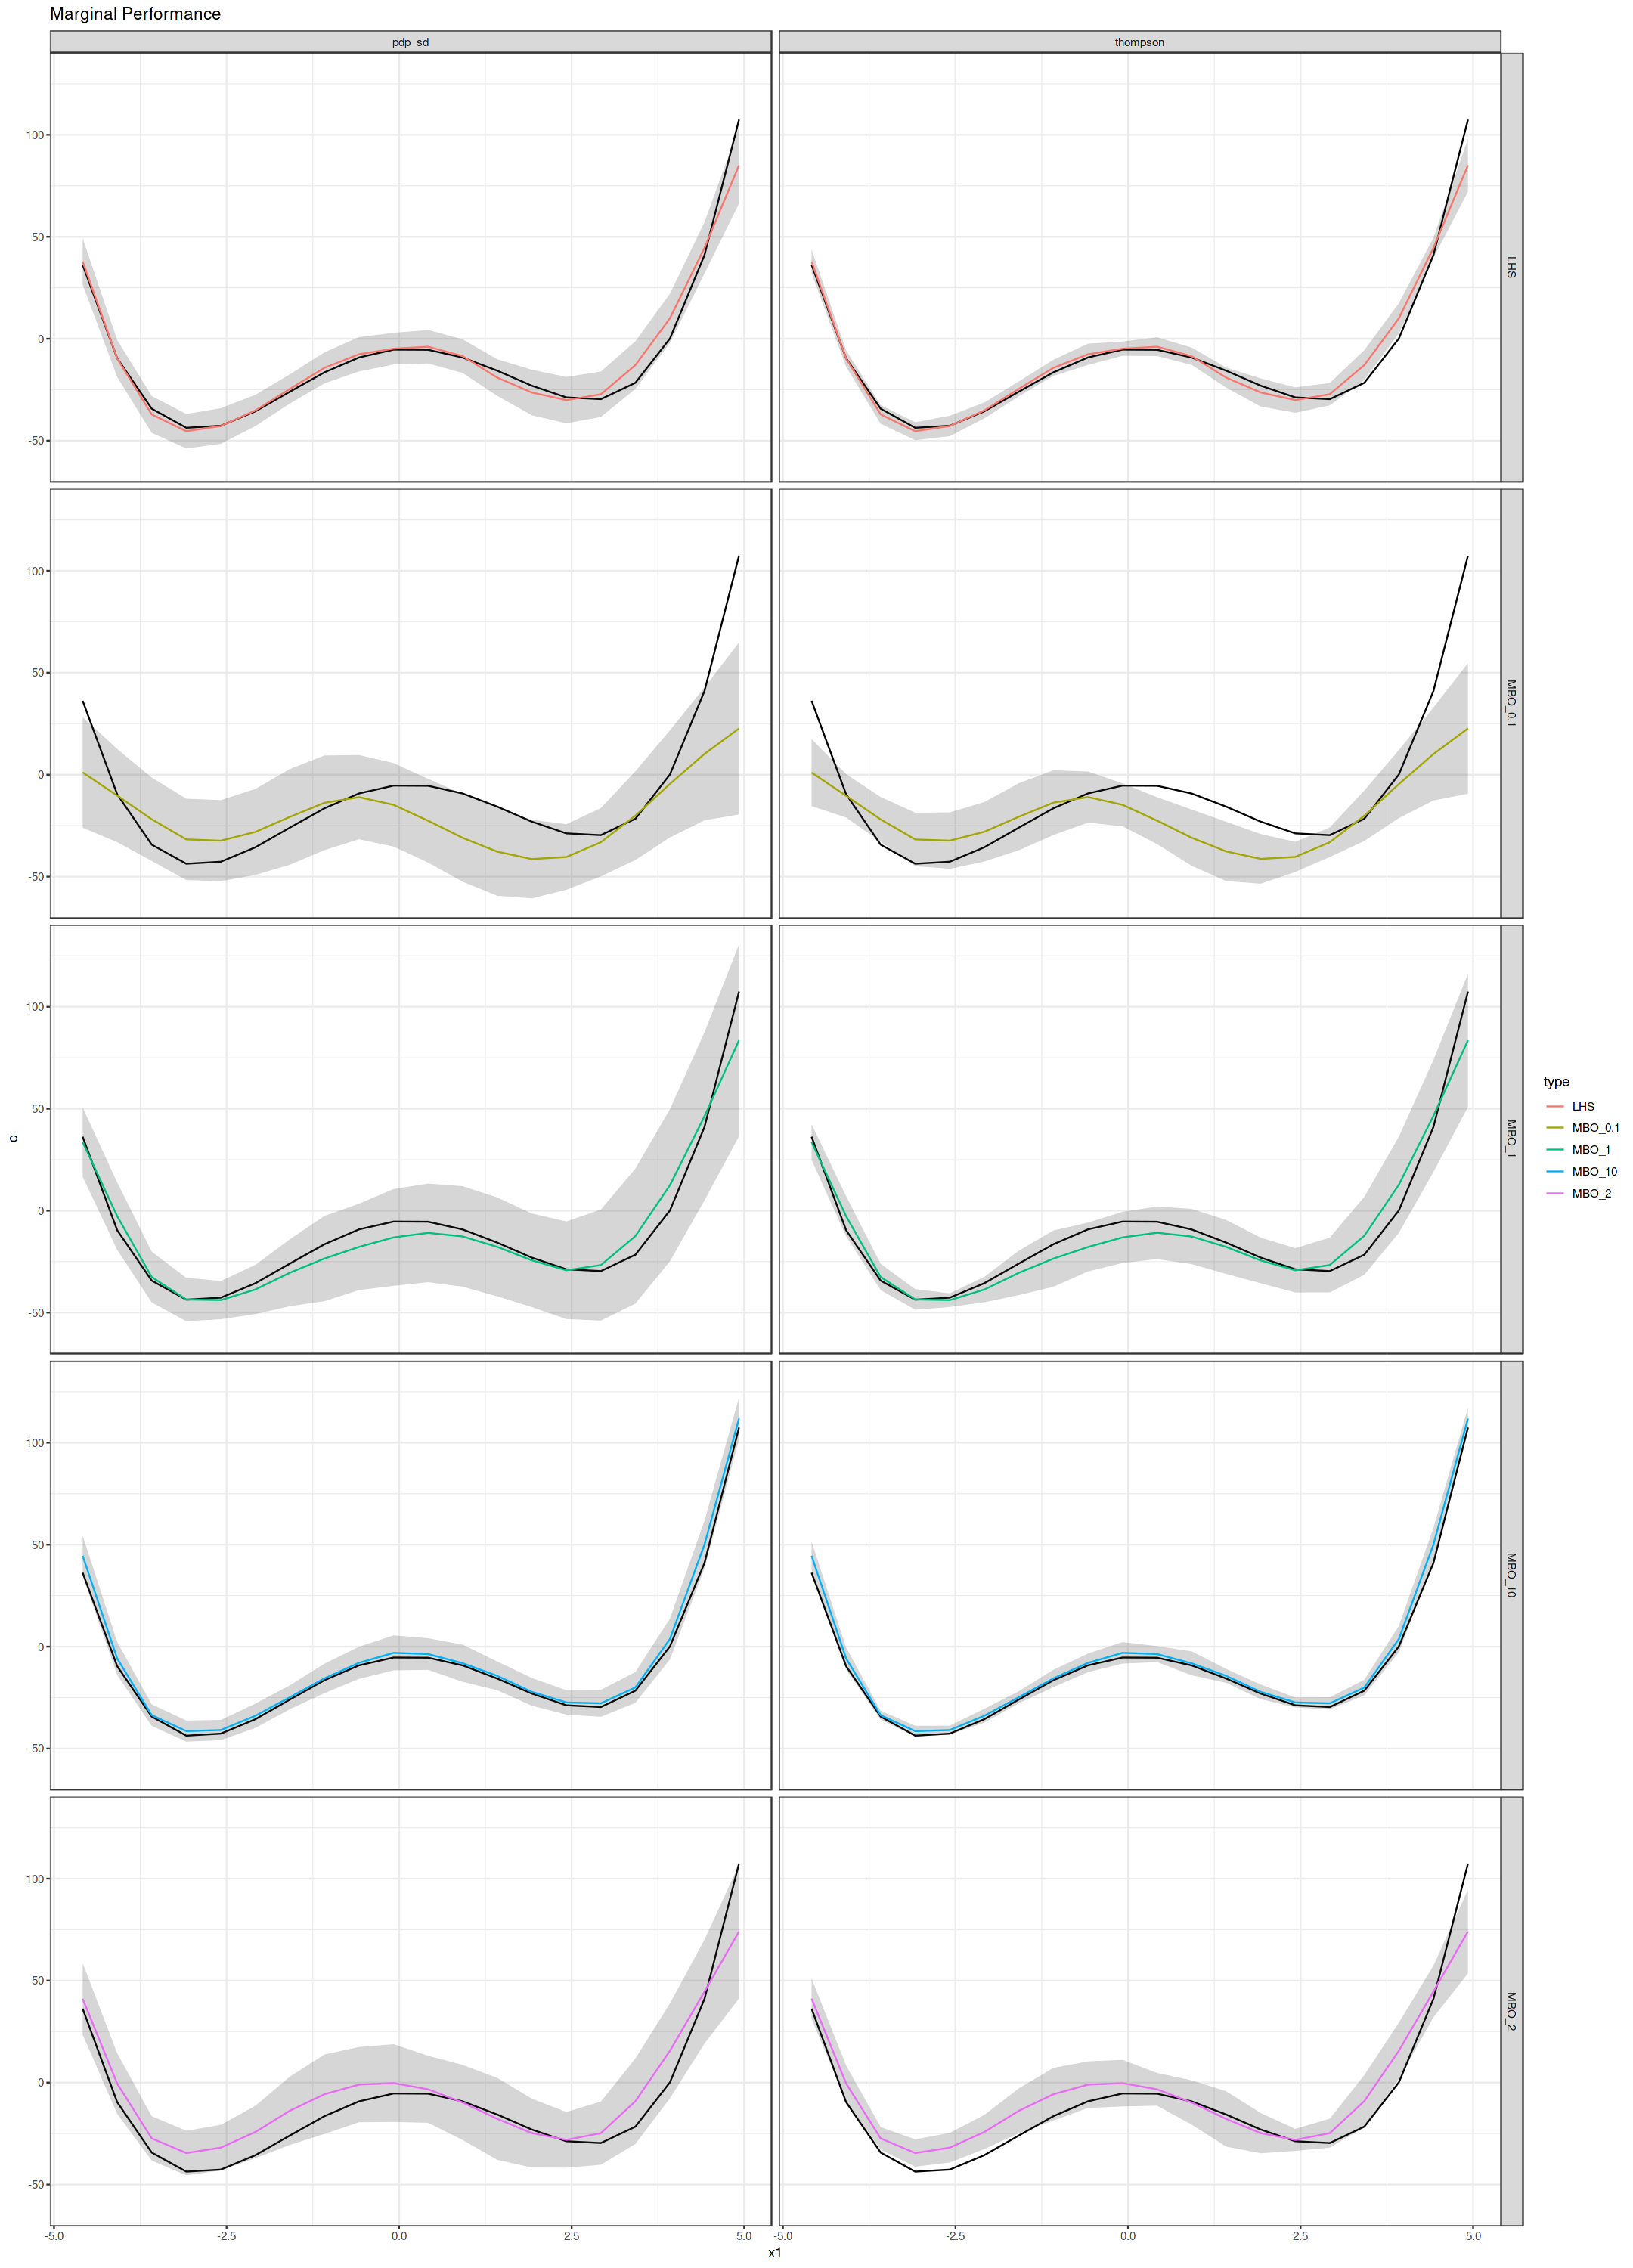

In [190]:
options(repr.plot.width=18, repr.plot.height=25)

pl = p + geom_ribbon(data = results[method %in% c("pdp_sd", "thompson"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_sd", "thompson"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
pl

In [191]:
# Alternative Approach 
results2 = list()

for (method in c("pdp_cond", "pdp_cond_thomps")) {
    res = lapply(names(models), function(m) {
        pp = conditional_mean_sd(models[[m]], "x1", data, method = method)
        pp$type = m
        pp
    })
    res = do.call(rbind, res)
    res$method = method
    results2[[method]] = res
}

In [192]:
results2 = do.call(rbind, results2)

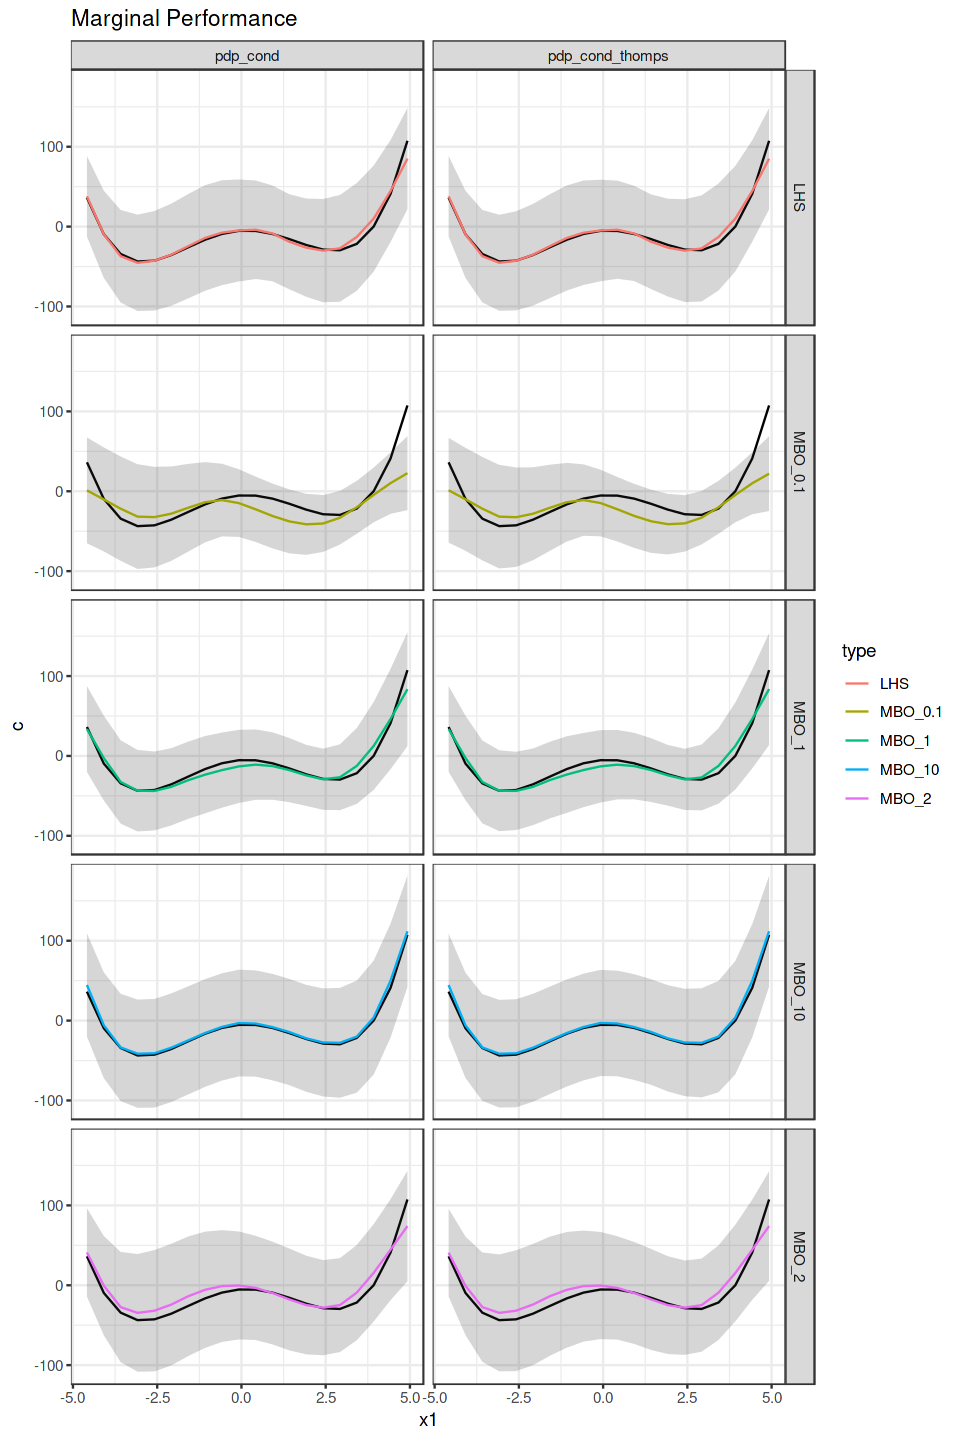

In [193]:
options(repr.plot.width=8, repr.plot.height=12)

pl = p + geom_ribbon(data = results2, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
pl = pl + geom_line(data = results2, aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
pl

## Further Visualization for the Paper

In [26]:
plotPDPICE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp+ice")
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }    
    return(p)
}

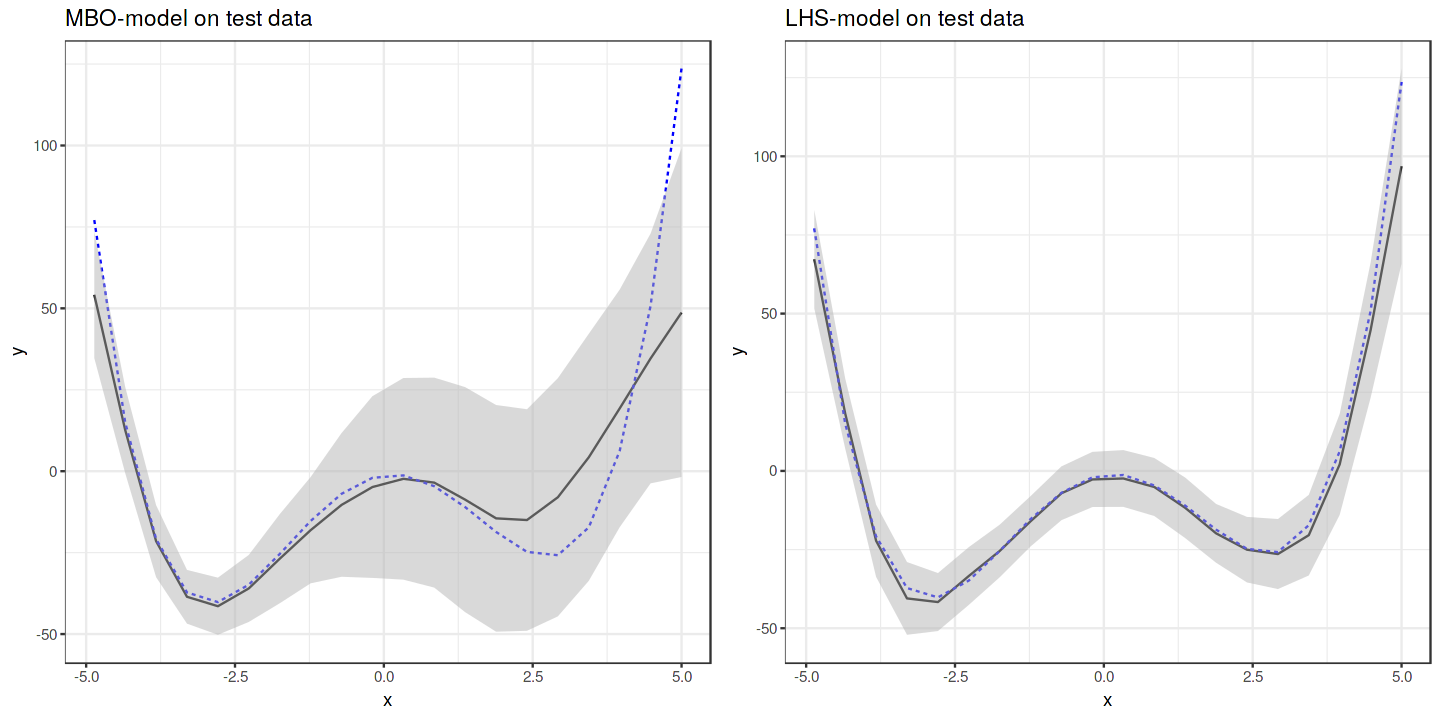

In [187]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("MBO-model on test data") 
p2 = plotPDP(obj1, "LHS", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("LHS-model on test data") 
grid.arrange(p1, p2, ncol = 2)

In [188]:
options(repr.plot.width = 8, repr.plot.height = 6)

preds = setDT(preds)

example_ice_curves = data.frame(y = c(2.5, -1), type = c("ice_curve_1", "ice_curve_2"))

# Explanation
p2 = ggplot() + geom_tile(data = preds[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 = p2 + geom_hline(data = example_ice_curves, aes(yintercept = y, colour = type))

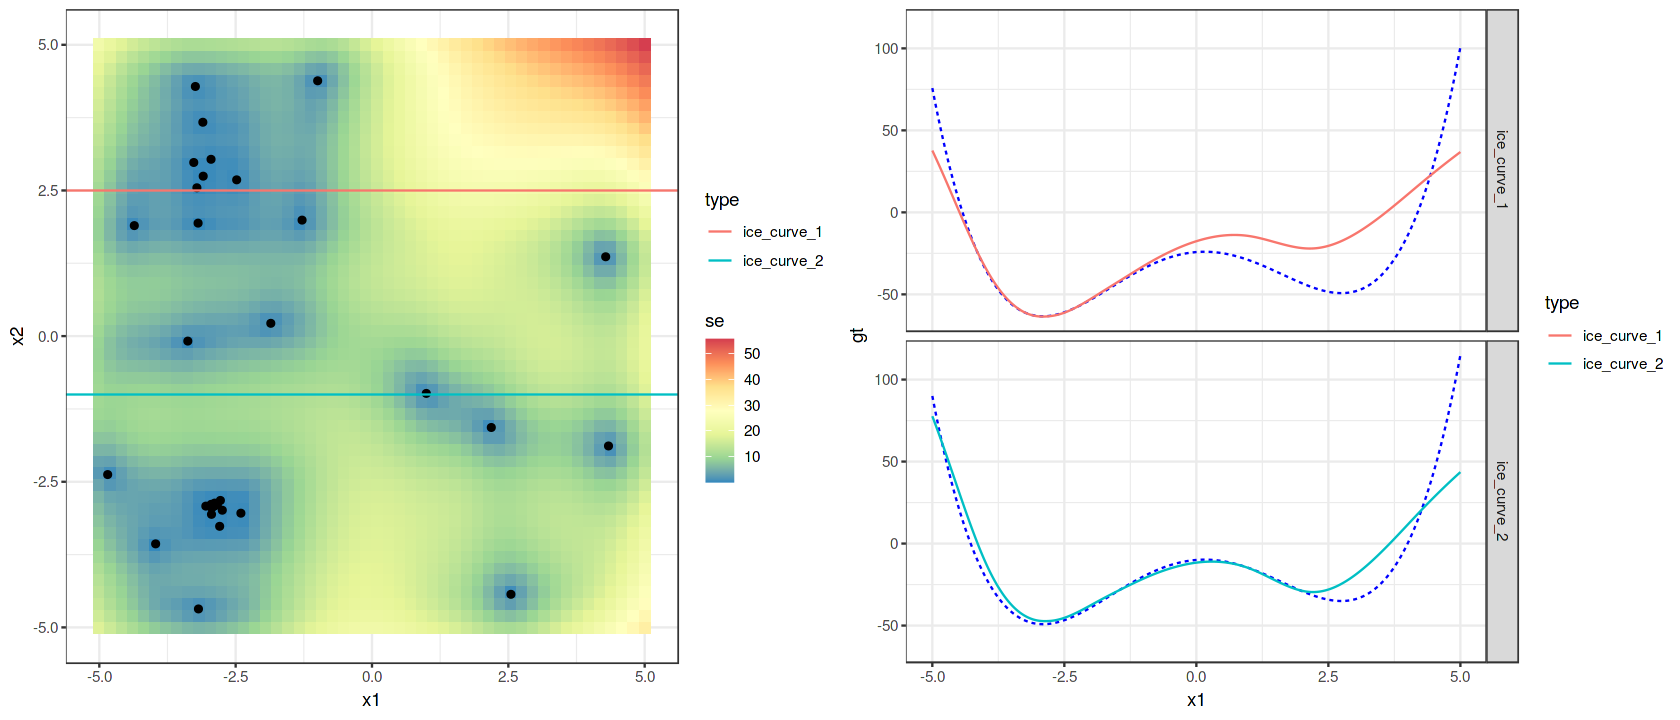

In [189]:
options(repr.plot.width = 14, repr.plot.height = 6)

x1 = seq(-5, 5, by = 0.01)
df_ice = data.frame(x1 = x1, x2 = example_ice_curves$y[1], type = "ice_curve_1")
df_ice = rbind(df_ice, data.frame(x1 = x1, x2 = example_ice_curves$y[2], type = "ice_curve_2"))
pred = predict(models[["lambda1"]], newdata = df_ice[, c("x1", "x2")])
df_ice$response = pred$data$response
df_ice$se = pred$data$se
df_ice$gt = apply(df_ice[, c("x1", "x2")], 1, obj1)

p1 = ggplot() 
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

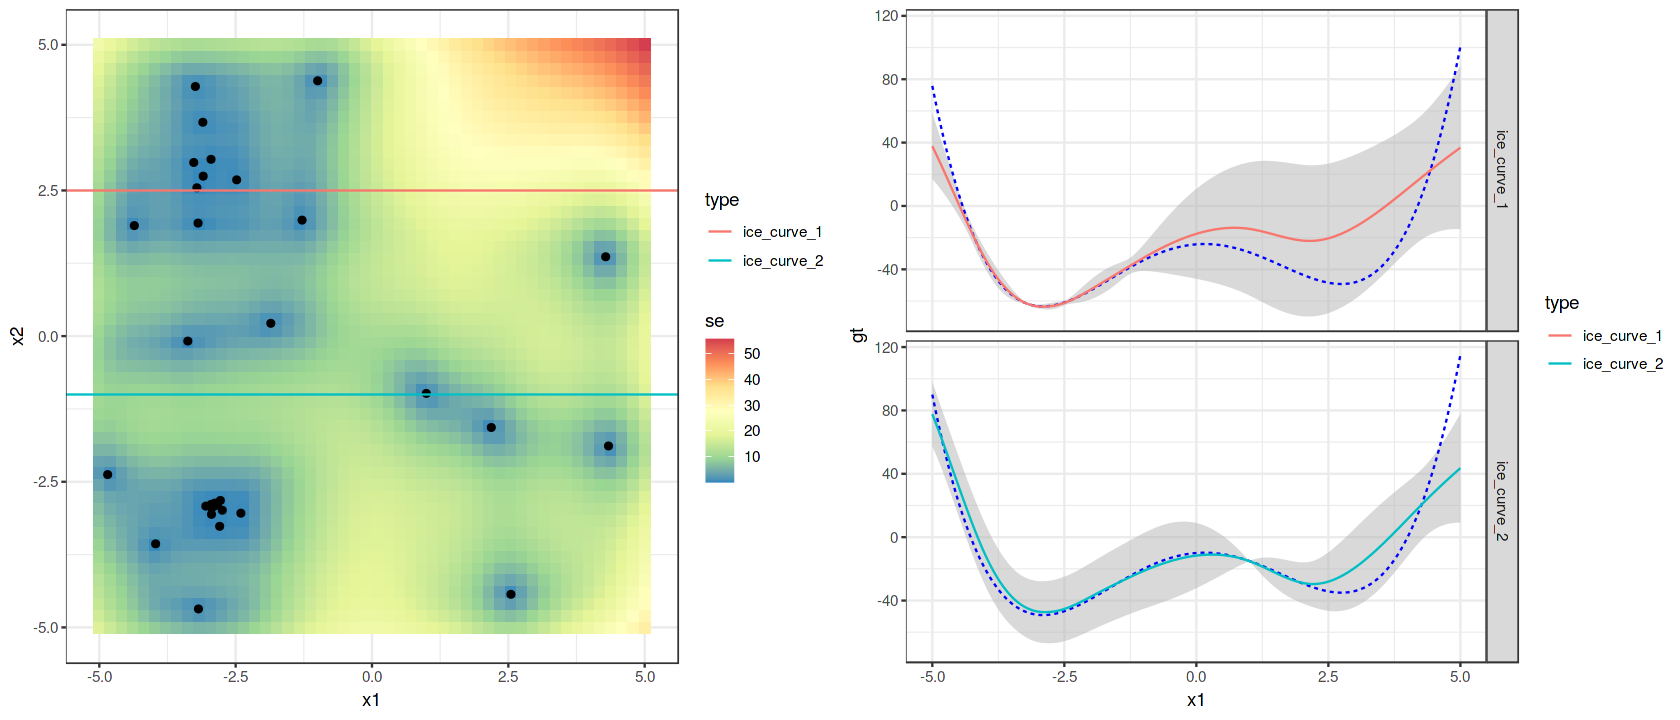

In [37]:
p1 = ggplot()
p1 = p1 + geom_ribbon(data = df_ice, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), fill = "grey70", alpha = 0.5)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

### Question 4: What Can We Do Against It? 

In [194]:
model_for_interpretation = "MBO_1"
model = models[[model_for_interpretation]]

In [195]:
# We now fit a tree to the se of the model to extract regions with low uncertainty
train_data_tree = generateDesign(n = 1000, par.set = ps, fun = lhs::randomLHS)
pred = predict(model, newdata = train_data_tree)

train_data_tree$response = pred$data$response
train_data_tree$se = pred$data$se

lrn_tree = makeLearner("regr.rpart", par.vals = list(maxdepth = 4, minbucket = 50, cp = 0.01))
task = makeRegrTask(data = train_data_tree[, c("x2", "se")], target = "se")
mod = train(lrn_tree, task)

In [196]:
getParamSet(lrn_tree)

                   Type len  Def   Constr Req Tunable Trafo
minsplit        integer   -   20 1 to Inf   -    TRUE     -
minbucket       integer   -    - 1 to Inf   -    TRUE     -
cp              numeric   - 0.01   0 to 1   -    TRUE     -
maxcompete      integer   -    4 0 to Inf   -    TRUE     -
maxsurrogate    integer   -    5 0 to Inf   -    TRUE     -
usesurrogate   discrete   -    2    0,1,2   -    TRUE     -
surrogatestyle discrete   -    0      0,1   -    TRUE     -
maxdepth        integer   -   30  1 to 30   -    TRUE     -
xval            integer   -   10 0 to Inf   -   FALSE     -

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


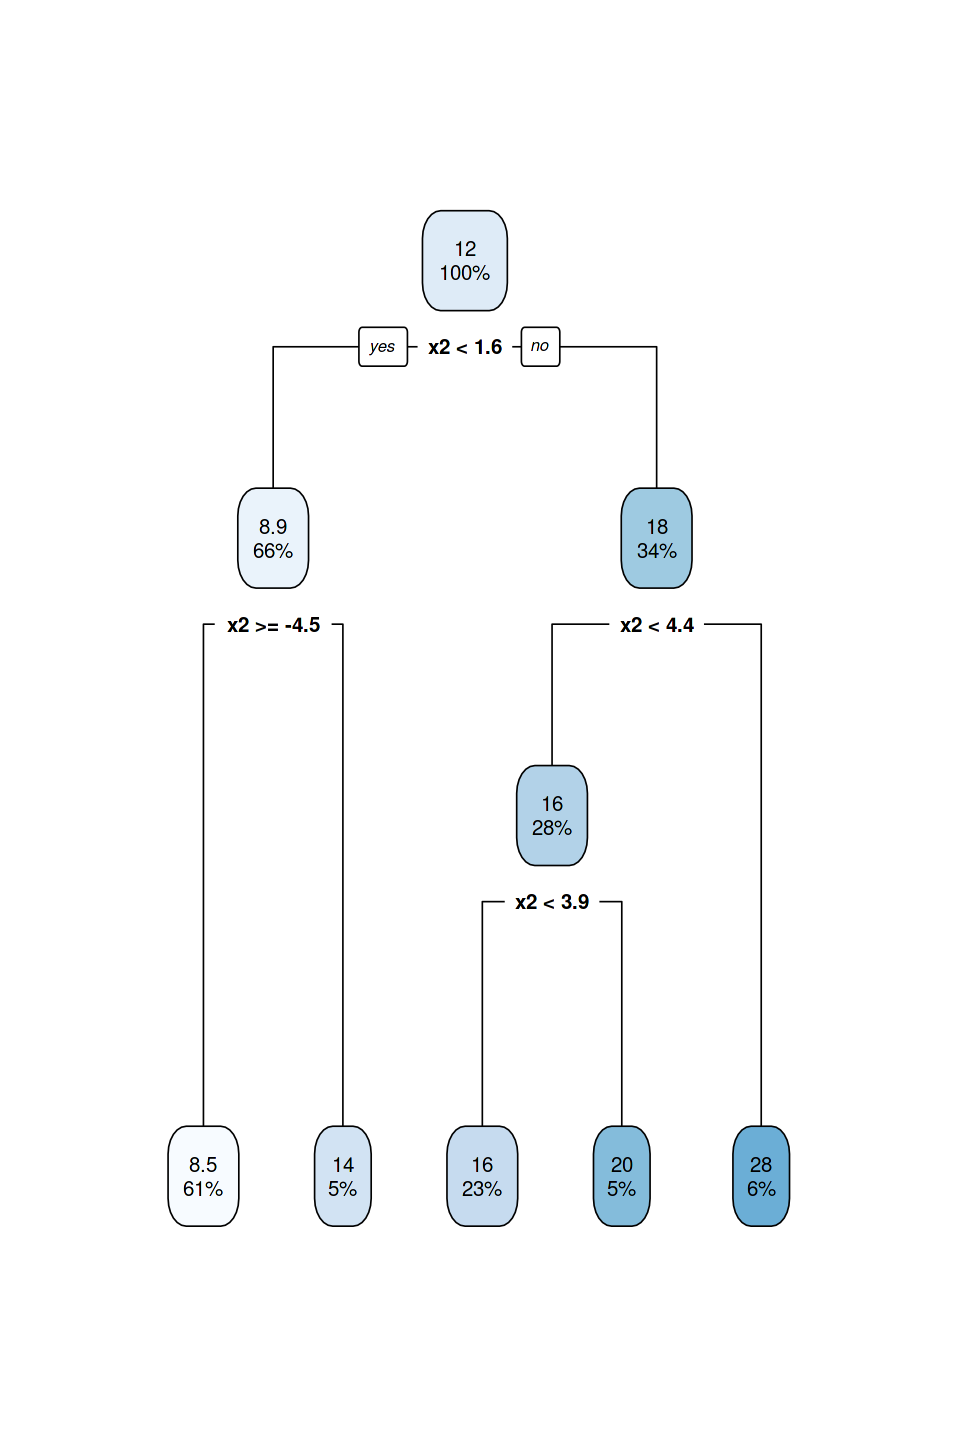

In [197]:
rpart.plot(mod$learner.model)

In [198]:
pred_rpart = predict(mod, task)

In [199]:
splits = as.data.frame(mod$learner.model$splits)$index
splits

[1]  1.636054 -4.497998  4.449471  3.930535

In [200]:
preds = as.data.table(preds)

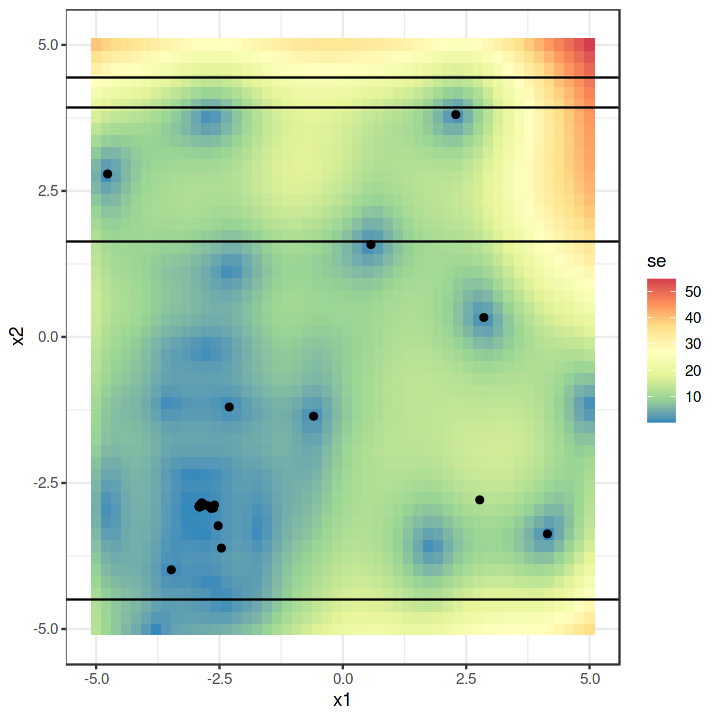

In [201]:
options(repr.plot.width = 6, repr.plot.height = 6)

p1 = ggplot(data = preds[type == model_for_interpretation, ], aes(x = x1, y = x2, fill = se)) + geom_tile() + geom_point(data = opdf[type == "MBO_0.1", ], aes(x = x1, y = x2)) 
p1 = p1 + geom_hline(yintercept = splits) + scale_fill_distiller(palette = "Spectral")
p1

In [203]:
rules = rpart.rules(mod$learner.model)
rules

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.rules with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


,se,,,,,,
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,8.5,when,x2,is,-4.5,to,1.6
5,13.9,when,x2,<,-4.5,,
12,15.7,when,x2,is,1.6,to,3.9
13,19.8,when,x2,is,3.9,to,4.4
7,27.8,when,x2,>=,,,4.4


Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


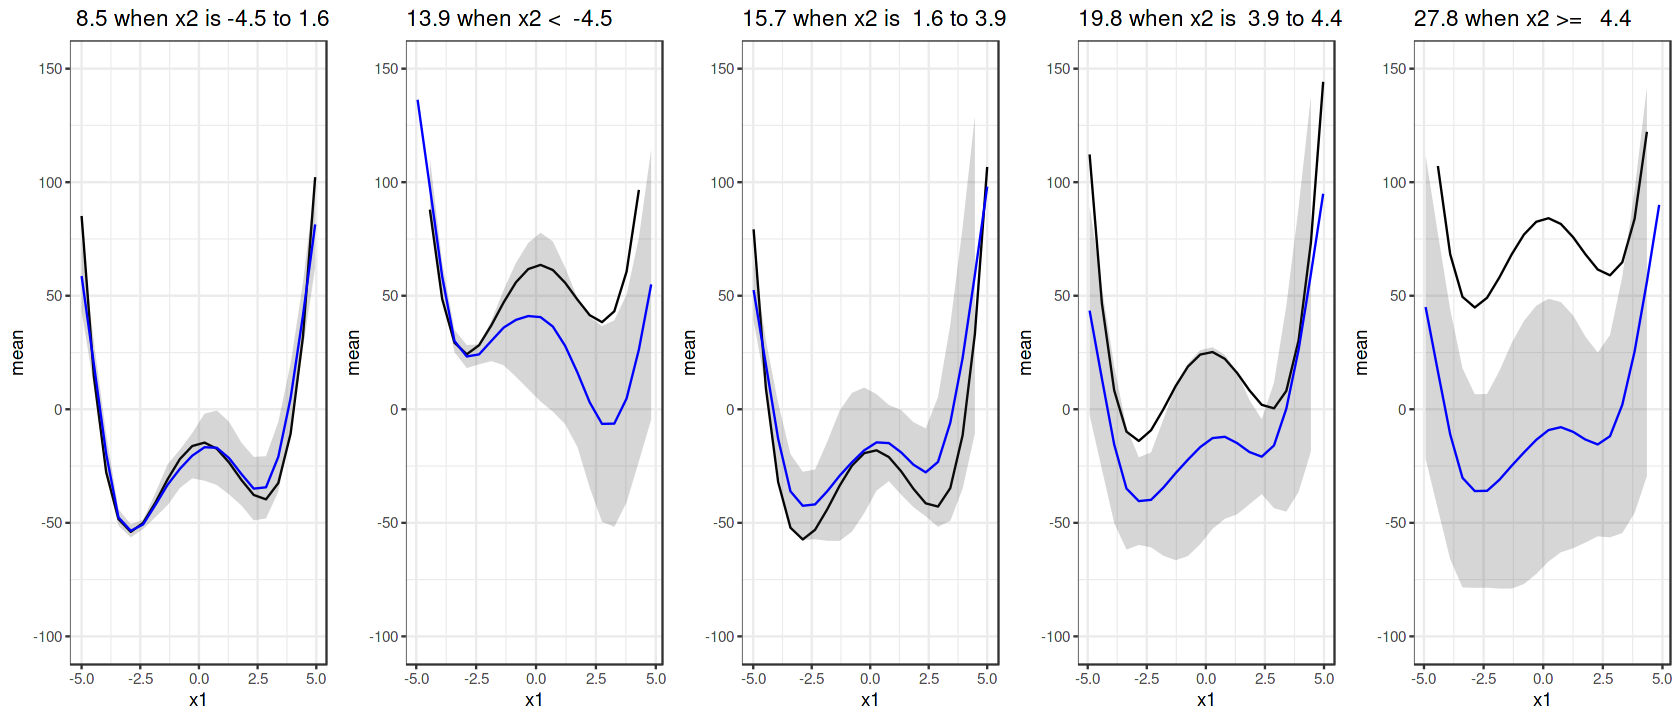

In [207]:
options(repr.plot.width = 14, repr.plot.height = 6)

pdd = predict(mod$learner.model)


sub_pdps = lapply(rownames(rules), function(node) {
    # First, get the value of that node
    yval = mod$learner.model$frame[node, ]$yval

    # Filter for those points where we have this predictions
    idx = which(pdd == yval)
    train_data_sub = train_data_tree[idx, ]

    gt_sub = marginal_effect(obj, "x1", train_data_sub)
    pd_sub = marginal_effect_sd_over_mean(model = model, feature = "x1", data = train_data_sub, method = "pdp_var_gp")

    p = ggplot(data = gt_sub, aes(x = x1, y = mean)) + geom_line()
    p = p + geom_ribbon(data = pd_sub, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
    p = p + geom_line(data = pd_sub, aes(x = x1, y = mean), colour = "blue") + ggtitle(do.call(paste, rules[node, ]))
    p + ylim(c(-100, 150))
})

do.call(grid.arrange, c(sub_pdps, nrow = 1))

In [ ]:
# Custom splitting criterion 
splitcrit = function(y, x, requires.x = FALSE) {
  ypred = mean(y)
  sum((y - ypred)^2)
}